In [ ]:
from torch import nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from torch.autograd import Variable
import gensim, logging
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pandas as pd
from pathlib import Path
from sklearn.metrics import classification_report

trainloader =  joblib.load('/content/drive/MyDrive/data_loader/train_data_loader.pkl')
valloader = joblib.load('/content/drive/MyDrive/data_loader/val_data_loader.pkl')
testloader = joblib.load('/content/drive/MyDrive/data_loader/test_data_loader.pkl')

BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(trainloader.dataset,batch_size= BATCH_SIZE, shuffle= True)
test_dataloader = torch.utils.data.DataLoader(testloader.dataset,batch_size= BATCH_SIZE)
val_dataloader = torch.utils.data.DataLoader(valloader.dataset,batch_size= BATCH_SIZE)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def F1_tensor(y_true, y_pred):
    y_true = y_true.to('cpu').numpy()
    y_pred = y_pred.to('cpu').numpy()
    return f1_score(y_true, y_pred)

def Confusion_matrix_tensor(y_true, y_pred):
    y_true = y_true.to('cpu').numpy()
    y_pred = y_pred.to('cpu').numpy()
    return f1_score(y_true, y_pred)

def convert_from_tensor(y): #convert from tensor to some kind of array that we can use numpy
    return y.cpu().detach().numpy().reshape(-1)

def take_all_elem(container, target):
    for x in target:
        if (x != 0 and x != 1):
            container.append(1)
        else:
            container.append(x)

def save_model(model):
    MODEL_PATH = Path('/content')
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    MODEL_NAME = 'best_RNNmodel.pth'
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    print(f'Update new best model to : {MODEL_SAVE_PATH}')
    torch.save(obj = model.state_dict(),f = MODEL_SAVE_PATH)

def train_step(model : nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_function : nn.Module,
               optimizer,
               device = 'cuda'):
    model.train()
    loss = 0

    all_y_true = []
    all_y_pred = []

    for (X_train,y_train) in data_loader:
        X_train = X_train.to(device)
        y_train = y_train.unsqueeze(1).to(device)

        y_pred = model(X_train)
        y_pred01 = torch.round(torch.sigmoid(y_pred))

        batch_loss = loss_function(y_pred.float(),y_train.float())
        loss += batch_loss

        take_all_elem(all_y_true,convert_from_tensor(y_train))
        take_all_elem(all_y_pred,convert_from_tensor(y_pred01))


        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    loss /= len(data_loader)

    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)

    #print(all_y_true)
    #print(np.unique(all_y_true))

    print('------------------Train Result----------------------------')
    print(f'Training loss : {loss} | F1_score : {f1_score(all_y_true,all_y_pred)}')
    print(f'Confusion matrix :')
    print(confusion_matrix(all_y_true,all_y_pred))
    print(f'Classification report :')
    print(classification_report(all_y_true, all_y_pred, digits=4))
    return loss

def test_step(model : nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_function : nn.Module,
              optimizer,
              device = 'cuda'):

    model.eval()
    loss,acc = 0,0

    all_y_true = []
    all_y_pred = []

    with torch.inference_mode():
        loss = 0

        for (X_test,y_test) in data_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            test_logits = model(X_test).squeeze()
            test_01 = torch.round(torch.sigmoid(test_logits))

            batch_loss = loss_function(test_logits.float(),y_test.float())

            loss += batch_loss

            take_all_elem(all_y_true,convert_from_tensor(y_test))
            take_all_elem(all_y_pred,convert_from_tensor(test_01))


        loss /= len(data_loader)
        acc /= len(data_loader)
    current_f1_score = f1_score(all_y_true,all_y_pred)
    print('------------------Test Result----------------------------')
    print(f'Testing loss : {loss} | F1_score : {f1_score(all_y_true,all_y_pred)}')
    global best_f1_score
    if (current_f1_score > best_f1_score):
        best_f1_score = current_f1_score
        #save_model(model)
    print(f'Confusion matrix :')
    print(confusion_matrix(all_y_true,all_y_pred))
    print(f'Classification report :')
    print(classification_report(all_y_true, all_y_pred, digits=4))
    print('---------------------------------------------------------')
    return loss
matrix_size = (64001,768)
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_output):
        """
        lstm_output: Tensor of shape (batch_size, seq_len, hidden_dim)
        """
        # Compute attention scores
        attn_scores = self.attention(lstm_output).squeeze(-1)  # (batch_size, seq_len)
        attn_weights = F.softmax(attn_scores, dim=1)  # Normalize scores to probabilities

        # Compute context vector as weighted sum of LSTM outputs
        context = torch.bmm(attn_weights.unsqueeze(1), lstm_output).squeeze(1)  # (batch_size, hidden_dim)

        return context, attn_weights

class attRNNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(64001,matrix_size[1])
        self.rnn = nn.RNN(input_size = matrix_size[1],hidden_size = 32,
            num_layers = 3, batch_first = True, bidirectional = True)
        self.attention = Attention(32 * 2)
        self.fc = nn.LazyLinear(out_features = 1)

    #it output [0,1,2,....,seq_length - 1]
    #just take the last array element in case of classification or anything like that
    def forward(self, X, state=None):
        embedding = self.embedding(X)
        rnn_outputs, _ = self.rnn(embedding)
        context, attn_weights = self.attention(rnn_outputs)
        return self.fc(context)

class RNNmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(64001,matrix_size[1])
        self.rnn = nn.RNN(input_size = matrix_size[1],hidden_size = 32,
            num_layers = 3, batch_first = True, bidirectional = True)
        self.fc = nn.LazyLinear(out_features = 1)

    #it output [0,1,2,....,seq_length - 1]
    #just take the last array element in case of classification or anything like that
    def forward(self, X, state=None):
        embedding = self.embedding(X)
        rnn_outputs, _ = self.rnn(embedding)
        return self.fc(rnn_outputs[:,-1,:])

device = 'cuda'


In [ ]:
model = attRNNmodel().to(device)
BCE_loss = nn.BCEWithLogitsLoss()
Adam_optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.001)


epochs = 10
best_f1_score = -1

for epoch in range(0,epochs):
    print(f'Epoch {epoch}=======================================')
    train_step(model,train_dataloader,BCE_loss,Adam_optimizer,device = device)
    test_step(model,val_dataloader,BCE_loss,Adam_optimizer,device = device)
    #break

Epoch 0=======================================


KeyboardInterrupt: 

In [ ]:
model = RNNmodel().to(device)
BCE_loss = nn.BCEWithLogitsLoss()
Adam_optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.001)


epochs = 20
best_f1_score = -1
train_loss = []
val_loss = []
for epoch in range(0,epochs):
    print(f'Epoch {epoch}=======================================')
    epoch_train_loss = train_step(model,train_dataloader,BCE_loss,Adam_optimizer,device = device)
    train_loss.append(epoch_train_loss)
    epoch_val_loss = test_step(model,val_dataloader,BCE_loss,Adam_optimizer,device = device)
    val_loss.append(epoch_val_loss)

    #break

Epoch 0=======================================
------------------Train Result----------------------------
Training loss : 0.5782622694969177 | F1_score : 0.004000695773177944
Confusion matrix :
[[31696   105]
 [11347    23]]
Classification report :
              precision    recall  f1-score   support

           0     0.7364    0.9967    0.8470     31801
           1     0.1797    0.0020    0.0040     11370

    accuracy                         0.7347     43171
   macro avg     0.4580    0.4994    0.4255     43171
weighted avg     0.5898    0.7347    0.6250     43171

------------------Test Result----------------------------
Testing loss : 0.5881865620613098 | F1_score : 0.0
Confusion matrix :
[[3938    0]
 [1444    0]]
Classification report :
              precision    recall  f1-score   support

           0     0.7317    1.0000    0.8451      3938
           1     0.0000    0.0000    0.0000      1444

    accuracy                         0.7317      5382
   macro avg     0.3658    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


------------------Train Result----------------------------
Training loss : 0.57457035779953 | F1_score : 0.010307477288609364
Confusion matrix :
[[31782    19]
 [11311    59]]
Classification report :
              precision    recall  f1-score   support

           0     0.7375    0.9994    0.8487     31801
           1     0.7564    0.0052    0.0103     11370

    accuracy                         0.7376     43171
   macro avg     0.7470    0.5023    0.4295     43171
weighted avg     0.7425    0.7376    0.6279     43171

------------------Test Result----------------------------
Testing loss : 0.5898157358169556 | F1_score : 0.01467645096731154
Confusion matrix :
[[3894   44]
 [1433   11]]
Classification report :
              precision    recall  f1-score   support

           0     0.7310    0.9888    0.8406      3938
           1     0.2000    0.0076    0.0147      1444

    accuracy                         0.7256      5382
   macro avg     0.4655    0.4982    0.4276      5382
weight

In [ ]:
test_step(model,test_dataloader,BCE_loss,Adam_optimizer,device = device)

------------------Test Result----------------------------
Testing loss : 0.6195564270019531 | F1_score : 0.0380327868852459
Confusion matrix :
[[3886   66]
 [1401   29]]
Classification report :
              precision    recall  f1-score   support

           0     0.7350    0.9833    0.8412      3952
           1     0.3053    0.0203    0.0380      1430

    accuracy                         0.7274      5382
   macro avg     0.5201    0.5018    0.4396      5382
weighted avg     0.6208    0.7274    0.6278      5382

---------------------------------------------------------


tensor(0.6196, device='cuda:0')

In [ ]:
model = attRNNmodel().to(device)
model.load_state_dict(torch.load('best_attRNNmodel.pth'))
test_step(model,test_dataloader,BCE_loss,Adam_optimizer,device = device)

<ipython-input-15-8ab340b7a0b4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_attRNNmodel.pth'))


------------------Test Result----------------------------
Testing loss : 0.33853378891944885 | F1_score : 0.7061486231610713
Update new best model to : /content/best_RNNmodel.pth
Confusion matrix :
[[3667  285]
 [ 494  936]]
Classification report :
              precision    recall  f1-score   support

           0     0.8813    0.9279    0.9040      3952
           1     0.7666    0.6545    0.7061      1430

    accuracy                         0.8553      5382
   macro avg     0.8239    0.7912    0.8051      5382
weighted avg     0.8508    0.8553    0.8514      5382

---------------------------------------------------------


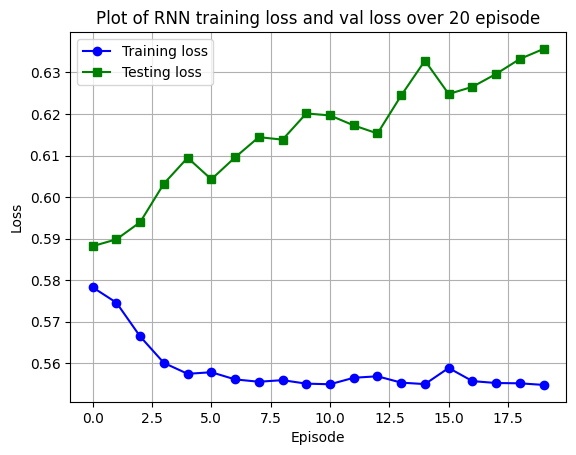

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert the lists of tensors to lists of CPU values
train_loss_cpu = [loss.cpu().item() for loss in train_loss]
val_loss_cpu = [loss.cpu().item() for loss in val_loss]

# Plot the arrays
plt.plot(train_loss_cpu, marker='o', label='Training loss', color='blue')
plt.plot(val_loss_cpu, marker='s', label='Testing loss', color='green')

# Add titles and labels
plt.title('Plot of RNN training loss and val loss over 20 episode')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [ ]:
class GRUmodel(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = nn.Embedding(64001, 768)
        self.rnn = nn.GRU(input_size = matrix_size[1],hidden_size = 384,
            num_layers = 3, batch_first = True, bidirectional = False)

        self.fc = nn.LazyLinear(out_features = 1)

    #it output [0,1,2,....,seq_length - 1]
    #just take the last array element in case of classification or anything like that
    def forward(self, X, state=None):
        X = self.embedding(X)
        rnn_outputs, _ = self.rnn(X, state)

        return self.fc(rnn_outputs[:, -1, :])


In [ ]:
import joblib

model = GRUmodel().to(device)
# Load the model using joblib
loaded_model = joblib.load('/content/drive/MyDrive/data_loader/gru_model.pkl')
# Assuming 'loaded_model' is the actual model object
model.load_state_dict(loaded_model.state_dict())  # Load the state dictionary
test_step(model, test_dataloader, BCE_loss, Adam_optimizer, device=device)

------------------Test Result----------------------------
Testing loss : 0.9040594100952148 | F1_score : 0.6877296105804556
Confusion matrix :
[[3596  356]
 [ 494  936]]
Classification report :
              precision    recall  f1-score   support

           0     0.8792    0.9099    0.8943      3952
           1     0.7245    0.6545    0.6877      1430

    accuracy                         0.8421      5382
   macro avg     0.8018    0.7822    0.7910      5382
weighted avg     0.8381    0.8421    0.8394      5382

---------------------------------------------------------


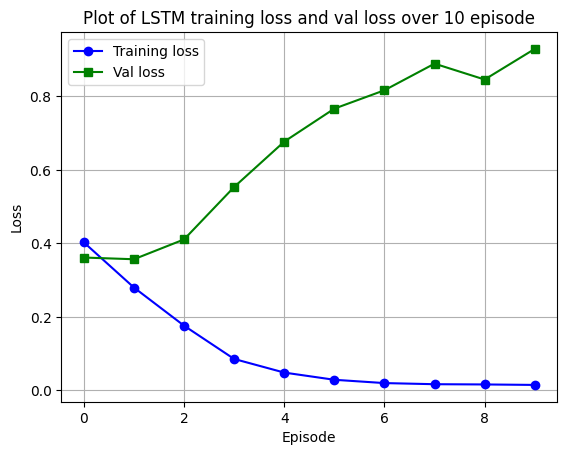

In [4]:
training_loss = [0.4027549624443054,0.28000539541244507,0.17630010843276978,0.08572310954332352,0.04871148243546486,0.0291376281529665,0.020146364346146584,0.01708260178565979,0.016425568610429764,0.015145350247621536]
val_loss = [0.36150553822517395,0.3568698465824127,0.4107227623462677,0.5532641410827637,0.6766282916069031,0.7663545608520508,0.8163372874259949,0.8887156248092651,0.84549880027771,0.9287515878677368]
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Plot the arrays
plt.plot(training_loss, marker='o', label='Training loss', color='blue')
plt.plot(val_loss, marker='s', label='Val loss', color='green')

# Add titles and labels
plt.title('Plot of LSTM training loss and val loss over 10 episode')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()



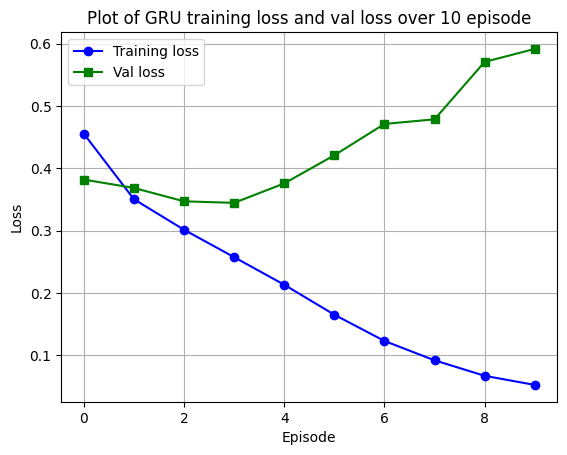

In [3]:
training_loss = [0.45532846450805664,0.3503006398677826,0.30131620168685913,0.2573848366737366,0.21317395567893982,0.16513261198997498,0.12299606949090958,0.09198715537786484,0.06715718656778336,0.05251249670982361]
val_loss = [0.3817872405052185,0.368364155292511,0.34692099690437317,0.34449970722198486,0.37564602494239807,0.4207930862903595,0.47103145718574524,0.4784201681613922,0.5705175399780273,0.5913235545158386]
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Plot the arrays
plt.plot(training_loss, marker='o', label='Training loss', color='blue')
plt.plot(val_loss, marker='s', label='Val loss', color='green')

# Add titles and labels
plt.title('Plot of GRU training loss and val loss over 10 episode')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()


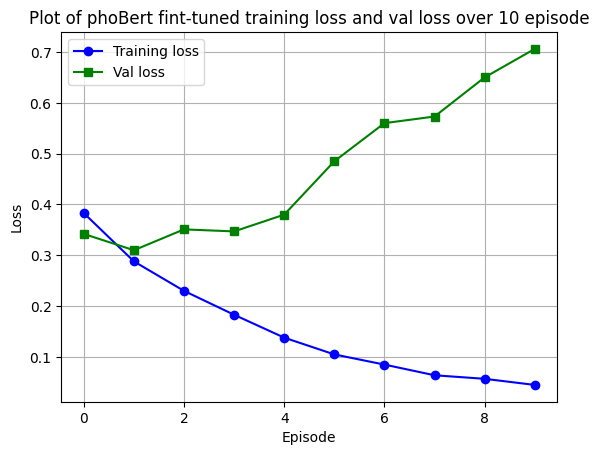

In [1]:
training_loss = [0.383,0.288,0.230,0.183, 0.138,0.105,0.085, 0.064, 0.057, 0.045]
val_loss = [0.342,0.310,0.351,0.347,0.380,0.485,0.560,0.573,0.650,0.706]
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Plot the arrays
plt.plot(training_loss, marker='o', label='Training loss', color='blue')
plt.plot(val_loss, marker='s', label='Val loss', color='green')

# Add titles and labels
plt.title('Plot of phoBert fint-tuned training loss and val loss over 10 episode')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()

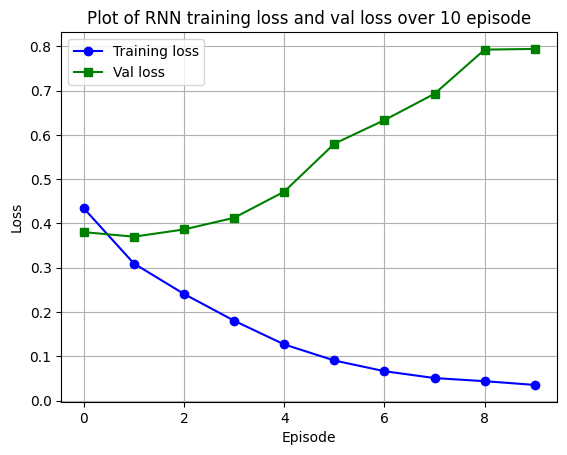

In [2]:
training_loss = [0.4341845214366913,0.3095458447933197,0.24085058271884918,0.1804116815328598,0.12688545882701874,0.09062687307596207,0.06645514816045761,0.05093738064169884,0.04391387104988098,0.03545396775007248]
val_loss = [0.3804588317871094,0.3701496422290802,0.38655325770378113,0.4128318727016449,0.47185033559799194,0.5801052451133728,0.6333915591239929,0.6928701400756836,0.7925480008125305,0.7941335439682007]
import matplotlib.pyplot as plt
import numpy as np
# Plot the arrays
plt.plot(training_loss, marker='o', label='Training loss', color='blue')
plt.plot(val_loss, marker='s', label='Val loss', color='green')

# Add titles and labels
plt.title('Plot of RNN training loss and val loss over 10 episode')
plt.xlabel('Episode')
plt.ylabel('Loss')

# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()